# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

  Описание данных:  

Данные геологоразведки трёх регионов находятся в файлах:  
• geo_data_0.csv. Скачать датасет  
• geo_data_1.csv. Скачать датасет  
• geo_data_2.csv. Скачать датасет  
• id — уникальный идентификатор скважины;  
• f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
• product — объём запасов в скважине (тыс. баррелей).  

  Условия задачи:  

• Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
• При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
• Бюджет на разработку скважин в регионе — 10 млрд рублей.  
• При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
• После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


## Загрузка и подготовка данных

Загрузим библиотеки с которыми будем работать

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Зададим необходимые константы

In [ ]:
state = 12345

Загрузим таблицы `geo_data_0, geo_data_1 и geo_data_2`

In [ ]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')
geo_data_all = [geo_data_0, geo_data_1, geo_data_2]

### Изучим информацию в таблицах

Оценим структуру данных таблиц `geo_data_0, geo_data_1 и geo_data_2`

In [ ]:
print('Структура данных таблицы geo_data_0:')
display(geo_data_0.head())
display(geo_data_0.info())

Структура данных таблицы geo_data_0:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [ ]:
print('Структура данных таблицы geo_data_1:')
display(geo_data_1.head())
display(geo_data_1.info())

Структура данных таблицы geo_data_1:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [ ]:
print('Структура данных таблицы geo_data_2:')
display(geo_data_2.head())
display(geo_data_2.info())

Структура данных таблицы geo_data_2:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропущенных значений нет. Типы данных в таблице корректные.

#### Найдем характерные значения таблиц

In [ ]:
print('Характерные значения таблицы geo_data_0.csv')
display(geo_data_0.describe().T)
print('Характерные значения таблицы geo_data_1.csv')
display(geo_data_1.describe().T)
print('Характерные значения таблицы geo_data_2.csv')
display(geo_data_2.describe().T)

Характерные значения таблицы geo_data_0.csv


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Характерные значения таблицы geo_data_1.csv


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Характерные значения таблицы geo_data_2.csv


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Бросается в глаза разница в значениях признаков второго региона (таблица `geo_data_1`)

#### Определим количество нулевых значений в столбцах таблиц

In [ ]:
print('Количество нулевых значений в столбцах таблицы geo_data_0')
display(geo_data_0.isin([0]).sum())
print('Количество нулевых значений в столбцах таблицы geo_data_1')
display(geo_data_1.isin([0]).sum())
print('Количество нулевых значений в столбцах таблицы geo_data_2')
display(geo_data_2.isin([0]).sum())

Количество нулевых значений в столбцах таблицы geo_data_0


id         0
f0         0
f1         0
f2         0
product    1
dtype: int64

Количество нулевых значений в столбцах таблицы geo_data_1


id            0
f0            0
f1            0
f2            0
product    8235
dtype: int64

Количество нулевых значений в столбцах таблицы geo_data_2


id         0
f0         0
f1         0
f2         0
product    1
dtype: int64

Обнаружены нулевые значения в столбце **product**. Больше всего их в таблице `geo_data_1` - 8235 значений. Возможная причина отображения нулей в таблице - в данных скважинах отсутствует нефть, изменять ничего не требуется.

#### Поиск явных дубликатов

In [ ]:
print('Общее количество дублей в таблице geo_data_0:', geo_data_0.duplicated().sum())
print('Общее количество дублей в таблице geo_data_1:', geo_data_1.duplicated().sum())
print('Общее количество дублей в таблице geo_data_2:', geo_data_2.duplicated().sum())

Общее количество дублей в таблице geo_data_0: 0
Общее количество дублей в таблице geo_data_1: 0
Общее количество дублей в таблице geo_data_2: 0


Определим количество дублей в полях таблиц

In [ ]:
print('Дубли в полях таблицы geo_data_0')
for column in geo_data_0:
    columnSeriesObj = geo_data_0[column]
    dup_values_count = columnSeriesObj.duplicated().sum()
    if dup_values_count != 0:
        print(columnSeriesObj.name, ':', dup_values_count)
    else:
        print(columnSeriesObj.name,': 0')

print('Дубли в полях таблицы geo_data_1')
for column in geo_data_1:
    columnSeriesObj = geo_data_1[column]
    dup_values_count = columnSeriesObj.duplicated().sum()
    if dup_values_count != 0:
        print(columnSeriesObj.name, ':', dup_values_count)
    else:
        print(columnSeriesObj.name,': 0')

print('Дубли в полях таблицы geo_data_2')
for column in geo_data_2:
    columnSeriesObj = geo_data_2[column]
    dup_values_count = columnSeriesObj.duplicated().sum()
    if dup_values_count != 0:
        print(columnSeriesObj.name, ':', dup_values_count)
    else:
        print(columnSeriesObj.name,': 0')

Дубли в полях таблицы geo_data_0
id : 10
f0 : 0
f1 : 0
f2 : 0
product : 0
Дубли в полях таблицы geo_data_1
id : 4
f0 : 0
f1 : 0
f2 : 0
product : 99988
Дубли в полях таблицы geo_data_2
id : 4
f0 : 0
f1 : 0
f2 : 0
product : 0


Посмотрим на дубли в поле id таблицы `geo_data_0`

In [ ]:
ids = geo_data_0["id"]
display(geo_data_0[ids.isin(ids[ids.duplicated()])].sort_values("id"))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Дубли обнаружены в полях **id** всех трех таблиц. Снова выделяется таблица `geo_data_1.csv` с полем **product** - 99988 дублей.   
- Значения признаков у дублей разнятся - такого не должно быть при взятии двух проб из одной скважины

#### Построим тепловую карту корреляции значений каждой таблицы

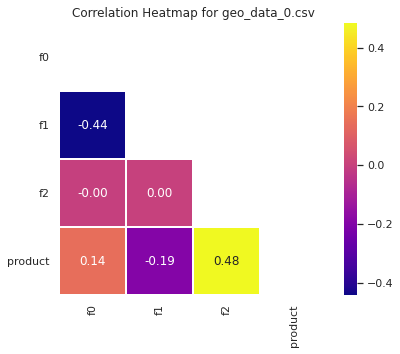

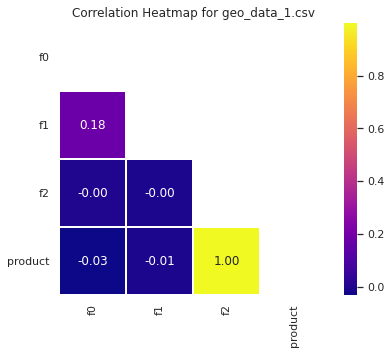

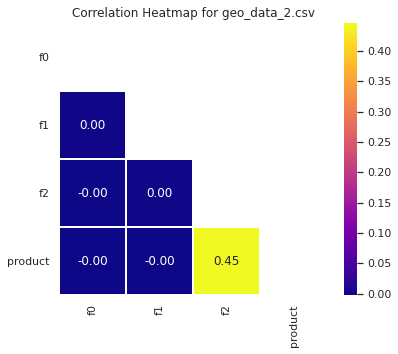

In [ ]:
count = -1
sns.set(style="whitegrid")
for df in geo_data_all:
    plt.figure(figsize= (6,5))
    mask = np.triu(np.ones_like(df.corr(),dtype = bool))
    sns.heatmap(df.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90)
    count += 1
    plt.title(f'Correlation Heatmap for geo_data_{count}.csv')
    plt.show()

#### Построим диаграмму рассеяния и посчитаем корреляцию между **product** и **f2** таблицы `geo_data_1`

<Figure size 900x600 with 0 Axes>

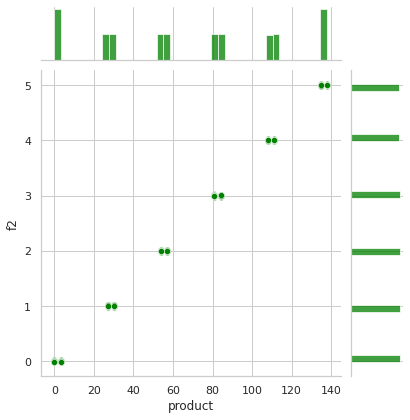

In [ ]:
plt.figure(dpi = 100, figsize = (9,6))
sns.jointplot(x='product',y='f2',data=geo_data_1,kind = 'scatter',color = 'green')
plt.show()

Очень сильная линейная зависимость объема запасов в скаважине **product** от признака **f2** в таблице `geo_data_1`. Это отразится на качестве модели линейной регрессии.

#### Построим сводные гистограмму и график плотности распределения обьемов запасов в скважинах

<Figure size 1152x648 with 0 Axes>

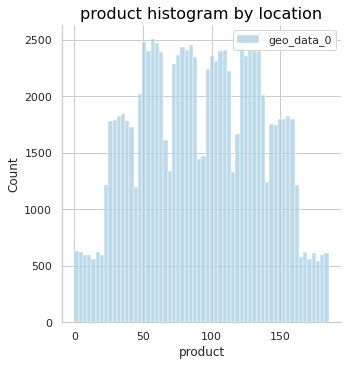

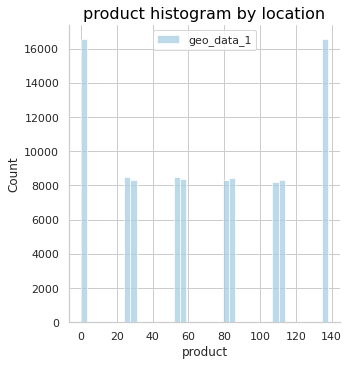

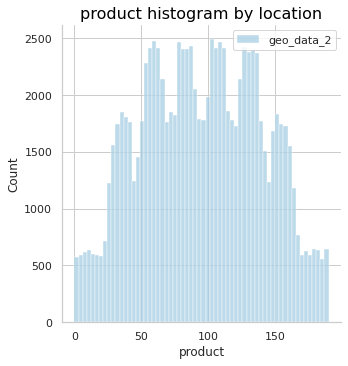

In [ ]:
plt.figure(figsize=(16,9))
sns.set_palette('Paired')
for i, df in enumerate (geo_data_all):
    df_name = f'geo_data_{i}'
    sns.displot(df['product'], label= df_name)
    plt.title('product histogram by location', loc='center', fontsize=16, fontweight=0, color='black')
    plt.legend()

Наблюдаются выбросы в таблице `geo_data_1` (много нулевых и максимальных значений **product**)

### Вывод:
 - Таблицы `geo_data_0, geo_data_1, geo_data_2` содержат по 100000 строк и 5 столбцов каждая (разделитель - запятая):  
 - **id** — уникальный идентификатор скважины (тип - `object`)
     - Обнаружены дубли:  
       - `geo_data_0` - 10 шт.  
       - `geo_data_1` - 4 шт.  
       - `geo_data_2` - 4 шт.  
 - Принцип обработки: Дубли можно удалить, так как их количество в выборке ничтожно мало.  
 - **f0, f1, f2** — три признака точек (тип - `float64`);  
 - **product** — объём запасов в скважине, тыс. баррелей (тип - `float64`)  
     - Обнаружены нулевые значения:  
       - `geo_data_0` - 1 шт.  
       - `geo_data_1` - 8235 шт.  
       - `geo_data_2` - 1 шт.  
     - Принцип обработки: Оставляем, как есть. Считаем, что в таких точках действительно мало нефти.  


Необходимо удалить дубли в поле **id**.    

Удалим столбец **id** так как это лишняя информация для оценки рентабельности региона.  
Отметим, что из трех таблиц выделяется (по значению признаков, большому количеству дублей в поле **product**) таблица `geo_data_1` (2-й регион). Наблюдается линейная зависимость объёма запасов в скважине **product** от признака **f2** в таблице `geo_data_1`. Данный факт должен повлиять на качество модели линейной регрессии.

Удалим дубли в поле **id** и **product**

In [ ]:
geo_data_0 = geo_data_0.drop_duplicates(subset = 'id').reset_index(drop = True)
geo_data_1 = geo_data_1.drop_duplicates(subset = 'id').reset_index(drop = True)
geo_data_2 = geo_data_2.drop_duplicates(subset = 'id').reset_index(drop = True)

Удалим поле **id**

In [ ]:
geo_data_0.drop('id', axis=1, inplace = True)
geo_data_1.drop('id', axis=1, inplace = True)
geo_data_2.drop('id', axis=1, inplace = True)

In [ ]:
geo_data_2.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


## Обучение и проверка модели

### Разобьем данные на выборки

Создадим переменные для признаков и целевого признака

In [ ]:
features_0 = geo_data_0.drop(['product'], axis=1)
target_0 = geo_data_0['product']

features_1 = geo_data_1.drop(['product'], axis=1)
target_1 = geo_data_1['product']

features_2 = geo_data_2.drop(['product'], axis=1)
target_2 = geo_data_2['product']

Разобъем данные на обучающую и валидационную выборки в соотношении 75:25

In [ ]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=state)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=state)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=state)

Создадим функцию расчета среднего запаса предсказанного сырья и RMSE модели

In [ ]:
def get_df_mean_rmse(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid)** 0.5
    mean = predicted_valid.mean()
    return rmse, mean, predicted_valid

Создадим таблицу для хранения результатов работы функции get_df_mean_rmse

In [ ]:
df_mean_rmse = {'model_n': [],
                'product_mean': [],
                'rmse': [],
               }

### Рассчитаем средние запасы предсказанного сырья и RMSE модели трех регионов

In [ ]:
rmse_0, mean_0, predicted_valid_0 = get_df_mean_rmse(features_train_0, target_train_0, features_valid_0, target_valid_0)
rmse_1, mean_1, predicted_valid_1 = get_df_mean_rmse(features_train_1, target_train_1, features_valid_1, target_valid_1)
rmse_2, mean_2, predicted_valid_2 = get_df_mean_rmse(features_train_2, target_train_2, features_valid_2, target_valid_2)

Заполним таблицу с результатами вычислений

In [ ]:
df_mean_rmse['model_n'].append('model_0')
df_mean_rmse['product_mean'].append(mean_0)
df_mean_rmse['rmse'].append(rmse_0)

df_mean_rmse['model_n'].append('model_1')
df_mean_rmse['product_mean'].append(mean_1)
df_mean_rmse['rmse'].append(rmse_1)

df_mean_rmse['model_n'].append('model_2')
df_mean_rmse['product_mean'].append(mean_2)
df_mean_rmse['rmse'].append(rmse_2)

display(pd.DataFrame(df_mean_rmse))

,model_n,product_mean,rmse
0,model_0,92.789156,37.853527
1,model_1,69.178320,0.892059
2,model_2,94.865725,40.075851


### Вывод:
 - Регионы 1 и 3 имеют схожие показатели по среднему запасу предсказанного сырья
 - Значение rmse минимально у 2-го региона (качество модели выше)

## Подготовка к расчёту прибыли

###### Зададим переменные, необходимые для расчетов

Количество точек для разведки

In [ ]:
boreholes_for_exploration = 500 # Из них 200 лучших для расчета прибыли
boreholes_for_revenue = 200

Бюджет на разаботку скважин в регионе

In [ ]:
budget = 1e10

Доход с единицы продукции

In [ ]:
unit_revenue = 4.5e5

## Расчёт прибыли и рисков

### Рассчитаем максимальную стоимость разработки одной скважины

In [ ]:
feasible_drilling_cost = budget / boreholes_for_revenue

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [ ]:
breakeven_units =  feasible_drilling_cost / unit_revenue
print('breakeven_units =', round(breakeven_units,2))

breakeven_units = 111.11


Любая точка с объемом запасов в скважине более `~111,11 тыс. баррелей` считается рентабельной.  
Это больше, чем средний запас в каждом из регионов.

Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [ ]:
def revenue(target_valid, predicted_valid, boreholes_for_revenue):
    probs_sorted = (pd.Series(predicted_valid)
                 #   .reset_index(drop = True)
                    .sort_values(ascending=False))
    selected = (pd.Series(target_valid)
                #.reset_index(drop = True)
                [probs_sorted.index][:boreholes_for_revenue]
               )
    return selected.sum()*unit_revenue - selected.count()*feasible_drilling_cost

Создадим функцию подсчета распределения прибыли при помощи техники Bootstrap (1000 выборок)

In [ ]:
def bootstrap(target_valid, predicted_valid, boreholes_for_exploration, boreholes_for_revenue):
    np_state = np.random.RandomState(state)
    revenue_values = [] # Создадим переменные для хранения результатов
    loss_values = []
    # Предобработаем входные данные, сбросим индексы
    target_valid = (pd.Series(target_valid)
                    .reset_index(drop = True)
                   )
    predicted_valid = (pd.Series(predicted_valid)
                    .reset_index(drop = True)
                   )
    for i in range(1000):
        target_subsample = target_valid.sample(n=boreholes_for_exploration, replace=True, random_state=np_state)
        probs_subsample = predicted_valid[target_subsample.index]

        # Посчитаем выручку и убытки
        if revenue(target_subsample, probs_subsample, boreholes_for_revenue) > 0:
            #revenue_values.append(revenue(target_subsample, probs_subsample, boreholes_for_revenue))
            revenue_values.append(revenue(target_valid, probs_subsample, boreholes_for_revenue))
        else:
            #loss_values.append(revenue(target_subsample, probs_subsample, boreholes_for_revenue))
            loss_values.append(revenue(target_valid, probs_subsample, boreholes_for_revenue))

    revenue_values = pd.Series(revenue_values)
    loss_values = pd.Series(loss_values)
    values = pd.concat([revenue_values, loss_values])

    # Посчитаем выходные параметры
    lower = values.quantile(q=0.025)
    upper = values.quantile(q=0.975)
    confidence_interval = (lower, upper)
    revenue_mean = values.mean()
    loss_prob= len(loss_values)/len(revenue_values)
    return round(revenue_mean/1000000,2), round(confidence_interval[0]/1000000,2), round(confidence_interval[1]/1000000,2), round(loss_prob *100,2)

Найдем расчетные величны при помощи функции bootstrap

In [ ]:
revenue_mean_0, conf_int_lower_0, conf_int_upper_0, prob_loss_0  = bootstrap(target_valid_0, predicted_valid_0, boreholes_for_exploration, boreholes_for_revenue)
revenue_mean_1, conf_int_lower_1, conf_int_upper_1, prob_loss_1  = bootstrap(target_valid_1, predicted_valid_1, boreholes_for_exploration, boreholes_for_revenue)
revenue_mean_2, conf_int_lower_2, conf_int_upper_2, prob_loss_2  = bootstrap(target_valid_2, predicted_valid_2, boreholes_for_exploration, boreholes_for_revenue)

Создадим таблицу для хранения результатов работы функции bootstrap

In [ ]:
bootstrap_details = {'geo_data_n': [],
                     'revenue_mean': [],
                     'conf_int_lower': [],
                     'conf_int_upper': [],
                     'prob_loss': []
                    }

bootstrap_details['geo_data_n'].append('geo_data_0') # Заполним таблицу с результатами вычислений
bootstrap_details['revenue_mean'].append(revenue_mean_0)
bootstrap_details['conf_int_lower'].append(conf_int_lower_0)
bootstrap_details['conf_int_upper'].append(conf_int_upper_0)
bootstrap_details['prob_loss'].append(prob_loss_0)

bootstrap_details['geo_data_n'].append('geo_data_1')
bootstrap_details['revenue_mean'].append(revenue_mean_1)
bootstrap_details['conf_int_lower'].append(conf_int_lower_1)
bootstrap_details['conf_int_upper'].append(conf_int_upper_1)
bootstrap_details['prob_loss'].append(prob_loss_1)

bootstrap_details['geo_data_n'].append('geo_data_2')
bootstrap_details['revenue_mean'].append(revenue_mean_2)
bootstrap_details['conf_int_lower'].append(conf_int_lower_2)
bootstrap_details['conf_int_upper'].append(conf_int_upper_2)
bootstrap_details['prob_loss'].append(prob_loss_2)

display(pd.DataFrame(bootstrap_details))

,geo_data_n,revenue_mean,conf_int_lower,conf_int_upper,prob_loss
0,geo_data_0,380.61,-142.94,890.98,7.64
1,geo_data_1,478.48,89.53,866.60,0.91
2,geo_data_2,330.55,-190.37,840.47,11.36


### Вывод:
 - В результатах видим, что, наиболее привлекательным для разработки выглядит 2-е месторождение `geo_data_1`. У данного месторождения:
      - наиболее высокая средняя прибыль - `478.48 млрд. рубл`.
      - наиболее узкий 95% доверительный интервал (более точная оценка)
      - вероятность убытков всего `0.91%` (соответствует условиям задачи: вероятность убытков меньше `2.5%`)   
      
      ###### Обратить внимание, на качество исходных данных `geo_data_1.csv`, вызывает вопросы (наличие выбросов, 100% корреляция и т.п.).  
      
      
   - Вторым кандидатом на разработку будет месторождение `geo_data_0`.